In [238]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

In [239]:

def compare(truth, 
            unif_w_pred = None, 
            exp_w_pred = None, 
            ip_pred = None,
            columnwise = False,
            verbose = False):
    """
    This function provides two things, conditional on the columnwise variable.
    columnwise = False: cross-model comparison of nrmse
    
    columnwise = True: model nrmse correlary for each point.
    """
    #ip_res =    #runInterpolation(columnwise = columnwise)
    
    if type(unif_w_pred) != type(None):
        unif_nrmse = nrmse(pred_ = unif_w_pred, truth = truth, columnwise = columnwise)
        
    if type(exp_w_pred) != type(None):
        exp_nrmse = nrmse(pred_  = exp_w_pred , truth = truth, columnwise = columnwise)
    
    if type(ip_pred) != type(None):
        ip_nrmse = nrmse(pred_  = ip_pred , truth = truth, columnwise = columnwise)
        
    ip_res = {"nrmse" : ip_nrmse, "pred" : ip_pred}
        
    
    assert type(columnwise) == bool, "columnwise must be a boolean"
    
    if columnwise == False:
        if verbose != False:
            print("cubic spline interpolation nrmse: " + str(ip_res["nrmse"]))
            print("uniform weights rc nrmse: " + str(unif_nrmse))
            print("exponential weights rc nrmse: " + str(exp_nrmse))
            print("creating barplot")
        if type(exp_w_pred) != type(None):
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse, 
                               "exponential rc" : exp_nrmse}, index = [0])
        else:
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse}, index = [0])
        display(df)

        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        sns.catplot(data = df, kind = "bar")
        plt.title("model vs nrmse")
        plt.ylabel("nrmse")
        improvement = []
        for rc_nrmse in[unif_nrmse, exp_nrmse]:
            impr_spec = ((ip_res["nrmse"] - rc_nrmse)/ip_res["nrmse"]) * 100
            impr_spec = [round(impr_spec,1)]
            improvement += impr_spec

        pct_improve_unif, pct_improve_exp = improvement
        if pct_improve_unif > 0:
            print("unif improvement vs interpolation: nrmse " + str(-pct_improve_unif) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_unif) + "%")
        
        if pct_improve_exp > 0:
            print("exp improvement vs interpolation: nrmse " + str(-pct_improve_exp) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_exp) + "%")

        impr_rc_compare = round(((unif_nrmse - exp_nrmse)/unif_nrmse) * 100,1)

        if impr_rc_compare > 0:
            print("exp rc improvement vs unif rc: nrmse " + str(-impr_rc_compare) + "%")
        else:
            print("exp weights didn't improve rc: nrmse +" + str(-impr_rc_compare) + "%")
    else:
        print("creating first figure")
        model_names = ["interpolation", "uniform rc", "exponential rc"]
        for i, model_rmse_np in enumerate([ip_res["nrmse"], unif_nrmse, exp_nrmse]):
            model_rmse_pd = pd.melt(pd.DataFrame(model_rmse_np.T))
            model_rmse_pd.columns = ["t","y"]
            model_rmse_pd["model"] = model_names[i]
            if i == 0:
                models_pd = model_rmse_pd
            else:
                models_pd = pd.concat([models_pd, model_rmse_pd ], axis = 0)
        fig, ax = plt.subplots(1,1, figsize = (11, 6))
        sns.lineplot(x = "t", y = "y", hue = "model", data = models_pd, ax = ax)
        ax.set_title("model vs rmse")
        ax.set_ylabel("nrmse")
        ax.set_xlabel("Test idx")
        
def get_experiment(json_obj, verbose = False):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs, 
                              plot_split = True)
    if verbose == True:
        print("experiment inputs: " + str(json_obj["experiment_inputs"]))
        print("get_obs_inputs: " + str(obs_inputs))
        print("Train.shape: " + str(experiment_.Train.shape))
        print("Saved_prediction.shape: " + str(np.array(json_obj["prediction"]["uniform"]).shape))
        
        
    
        
    experiment_.already_trained(json_obj["best arguments"]["uniform"])
    print(experiment_.prediction.shape)
    print(experiment_.Test.shape)
    
    
    experiment_.Train, experiment_.Test = recover_test_set(json_obj)
    ### which line is missing?
    xx = range(experiment_.prediction.shape[0])
    
    
    #plt.imshow( experiment_.prediction)
    #plt.show()
    """
    #plt.imshow( experiment_.Test)
    #plt.show()
    
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 0 ")
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 1 ")
    sns.lineplot( x = xx, y = experiment_.Test[ : , 0 ], label = "actual data 0")
    sns.lineplot( x = xx, y = experiment_.Test[ : , -1 ], label = "actual data 1")
    #plt.plot(experiment_.Test[ : , 1 ])
    """
    
    #experiment_.plot_timeseries(method = "avg")
    
    if len(list(json_obj["prediction"].keys())) == 3:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)
    if len(list(json_obj["prediction"].keys())) == 2:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = None,#np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)

    return(experiment_)
    
       
        #return(df)


In [240]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

def load_data(file = "default", print_lst = ["nrmse"], bp = None):
    if bp != None:
        file = bp + file
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    for i in print_lst:
        print(datt[i])
    return(datt)



#experiment.save_json(exp = False)
#fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
#fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "/Users/hayden/Desktop/experiment_results/2k/medium/",
            #base_path = #"./experiment_results/..."
            verbose = False,
            print_filestructure = False):
    
    print(base_path)
    fp = base_path + spec_path
    """
    targetKhz:_0.02__obskHz:_0.01.txt
    │   │   │   ├── targetKhz:_0.5__obskHz:_0.5.txt
    │   │   │   └── targetKhz:_0.5__obskHz:_1.0.txt
    """
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " +j)
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)

def recover_test_set(json_obj):
    """
    This function exists for an annoying reason: there is a shitty bug in my code.
    A timeline is dropped and surely this is minor if we can just recover the index by exact indices.
    """
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    

    
    obs_idx, resp_idx = json_obj["obs_idx"], json_obj["resp_idx"]
    A_subset = experiment_.A.copy()
    
    # pred shape
    pred_shape = np.array(json_obj["prediction"]["interpolation"]); pred_shape = pred_shape.shape[0]                   
    
    A = experiment_.A
    
    train_len = (A.shape[0] - pred_shape)
    Train_Tmp, Test_Tmp  = A[:train_len,resp_idx], A[train_len:,resp_idx]
    
    
    
    print(Test_Tmp.shape)
    return(Train_Tmp, Test_Tmp)

#recover_test_set(hi)

# New experiments

{'interpolation': 0.04193498294564275, 'uniform': 0.006715993145781358, 'exponential': 0.004791722441918638}


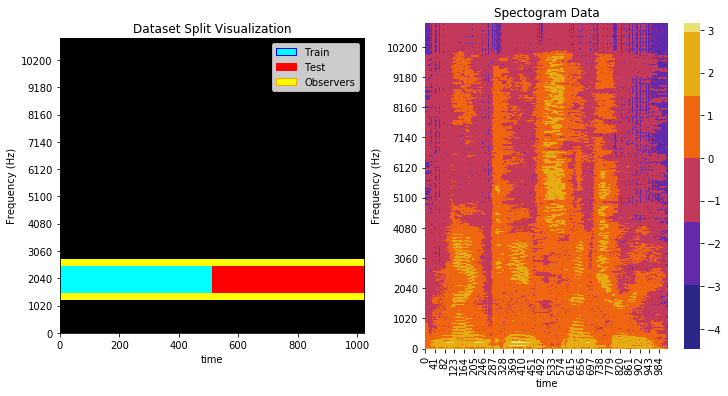

(512, 101)
(512, 52)
(512, 101)


,interpolation,uniform rc,exponential rc
0,6.421199,1.028371,0.733722


unif improvement vs interpolation: nrmse -84.0%
exp improvement vs interpolation: nrmse -88.6%
exp rc improvement vs unif rc: nrmse -28.7%
{'interpolation': 0.04276245645861106, 'uniform': 0.005478646854141667, 'exponential': 0.005082100503785801}


<Figure size 640x480 with 0 Axes>

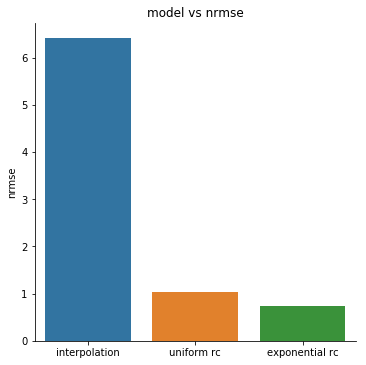

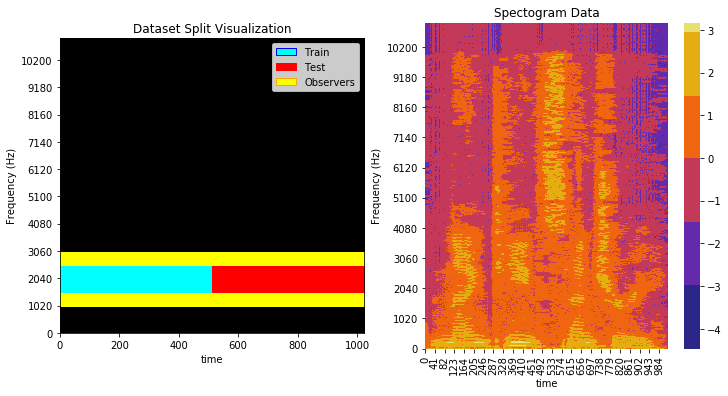

(512, 101)
(512, 102)
(512, 101)


,interpolation,uniform rc,exponential rc
0,6.547904,0.838905,0.778185


unif improvement vs interpolation: nrmse -87.2%
exp improvement vs interpolation: nrmse -88.1%
exp rc improvement vs unif rc: nrmse -7.2%
{'interpolation': 0.025478337983672262, 'uniform': 0.004610193500565042, 'exponential': 0.004378275016972765}


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

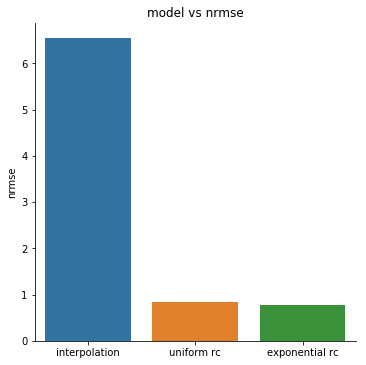

Error in callback <function flush_figures at 0x7fad20b7fcb0> (for post_execute):


KeyboardInterrupt: 

In [201]:

#experiment_4 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt")
#experiment_4_obj = get_experiment(experiment_4)

experiment_1 = load_data('./experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
experiment_1_obj = get_experiment(experiment_1)

#/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt


experiment_2 = load_data('./experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt')
experiment_2_obj = get_experiment(experiment_2)

experiment_3 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")
experiment_3_obj = get_experiment(experiment_3)



experiment_5 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt")
experiment_5_obj = get_experiment(experiment_5)

experiment_6 = load_data("./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt")
experiment_6_obj = get_experiment(experiment_6)

experiment_7 = load_data("./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt")
experiment_7_obj = get_experiment(experiment_7)

experiment_8 = load_data('./experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt')
experiment_8_obj = get_experiment(experiment_8)

experiment_9 = load_data('./experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt')
experiment_9_obj = get_experiment(experiment_9)

#experiment_10 = load_data('./experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt')
#experiment_10_obj = get_experiment(experiment_10)



experiment_lst = [experiment_1, experiment_2, experiment_3, #experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8, experiment_9]







In [241]:
#experiment_new = load_data('./experiment_results/2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt')
#get_experiment(experiment_new)

#experiment_new = load_data('./experiment_results/4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt')
#get_experiment(experiment_new)
print("hi")

hi


In [242]:
pd.read_csv?

In [264]:

complete_experiment_path_lst = [ 
            #2k, 0.9 COMPLETE
            './experiment_results/2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            './experiment_results/2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            './experiment_results/2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            './experiment_results/2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
    
            #2k, 0.5 COMPLETE
            './experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
            './experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt', #no exp
            #'./experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #no exp
            './experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt', #no exp
    
             #'./experiment_results/2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt', #no exp
    
           #4k, 0.9 COMPLETE
           "./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
           "./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
           './experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
           './experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',

           #4k 0.5 MISSING ONE
           './experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt',
           "./experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
           "./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt",
           
           "./experiment_results/4k/medium/split_0.5/targetKhz:_2.0__obskHz:_0.5.txt", #no exp
           "./experiment_results/4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt", #no exp
    
           #4k 0.5, bigger and better! 
           "./experiment_results/4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt", 
           "./experiment_results/4k/medium/split_0.5/targetKhz:_2.0__obskHz:_2.0.txt", 
    
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_3.0__obskHz:_0.5.txt",
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_3.0__obskHz:_1.0.txt",
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_3.0__obskHz:_2.0.txt",
            
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_4.0__obskHz:_0.5.txt", #??? broken
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_4.0__obskHz:_1.0.txt", #??? broken
           #"./experiment_results/4k/medium/split_0.5/targetKhz:_4.0__obskHz:_2.0.txt", #??? broken
    
    
           # MORE DETAIL:, given that the others aren't converging. 
         ]

experiment_lst = [ load_data(path) for path in complete_experiment_path_lst]

# fix nrmse calculation:
for i in range(len(experiment_lst)):
    #print(i)
    hi_train_set, hi_test_set = recover_test_set(experiment_lst[i]) 
    models_spec = experiment_lst[i]["prediction"].keys()
    for model_ in models_spec:
        pred_ = experiment_lst[i]["prediction"][model_]
        corrected_nrmse = nrmse(pred_, hi_test_set)
        experiment_lst[i]["nrmse"][model_] =corrected_nrmse


{'interpolation': 0.03955239119477351, 'uniform': 0.008112797145990952, 'exponential': 0.007922620399653035}
{'interpolation': 0.03909516122428118, 'uniform': 0.00879400672287924, 'exponential': 0.00841522296880583, 'hybrid': 0.008263297099248368}
{'interpolation': 0.04054741409444091, 'uniform': 0.004950837488748576, 'exponential': 0.004467446642837191}
{'interpolation': 0.03935121434238906, 'uniform': 0.0055532371962289575, 'exponential': 0.004923764286437881, 'hybrid': 0.004823417120348724}
{'interpolation': 0.04276245645861106, 'uniform': 0.005478646854141667, 'exponential': 0.005082100503785801}
{'interpolation': 0.04193498294564275, 'uniform': 0.006715993145781358, 'exponential': 0.004791722441918638}
{'interpolation': 0.03141803605667493, 'uniform': 0.009867320349121808, 'exponential': 0.007852101759821262}
{'interpolation': 0.02848427380953808, 'uniform': 0.01115500669957027, 'exponential': 0.003276000815674738}
{'interpolation': 0.029380444754227717, 'uniform': 0.0040346247324

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 2000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 2000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 2000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 2000.0]
[500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 500.0, 500.0, 1000.0, 1000.0, 500.0, 500.0, 1000.0, 2000.0, 2000.0, 2000.0, 2000.0, 500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 500.0, 500.

,interpolation,uniform,exponential,hybrid
0,2.463583,0.505318,0.493473,NaN
0,2.435104,0.547749,0.524155,0.514692
0,4.045366,0.493939,0.445712,NaN
0,3.926023,0.554040,0.491238,0.481226
0,6.547904,0.838905,0.778185,NaN
0,6.421199,1.028371,0.733722,NaN
0,3.182606,0.999547,0.795408,NaN
0,2.101481,0.822982,0.241693,NaN
0,2.167598,0.297662,0.285928,NaN
0,3.707667,0.419049,0.426176,NaN


,experiment,model,nrmse,obs hz,target hz
0,0,uniform,0.505318,500.0,500.0
1,1,uniform,0.547749,1000.0,500.0
2,2,uniform,0.493939,500.0,1000.0
3,3,uniform,0.554040,1000.0,1000.0
4,4,uniform,0.838905,1000.0,1000.0
...,...,...,...,...,...
67,13,NaN,NaN,1000.0,1000.0
68,14,NaN,NaN,500.0,2000.0
69,15,NaN,NaN,1000.0,2000.0
70,16,NaN,NaN,1000.0,2000.0


Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

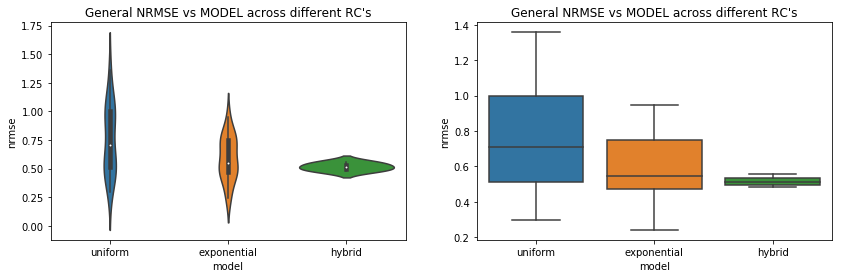

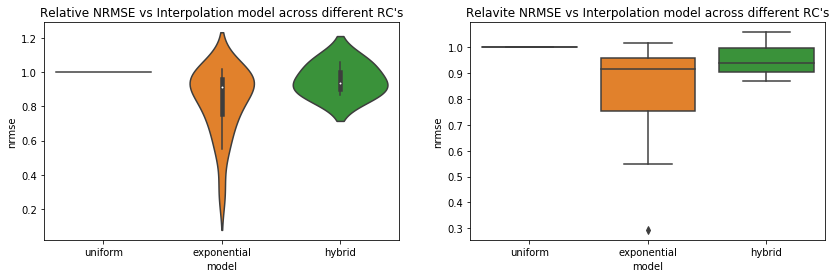

In [268]:
IGNORE_IP = True


def quick_dirty_convert(lst):
    lst *= 4
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    
    
    df_spec_rel = df_spec.copy()
    if IGNORE_IP == True:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["uniform"]#
    else:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

df_net = df_rel.copy()
        
obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
display(df)
if IGNORE_IP == True:
    df_rel = df_rel.drop(columns = ["interpolation"])
    df = df.drop(columns = ["interpolation"])

df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 

display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

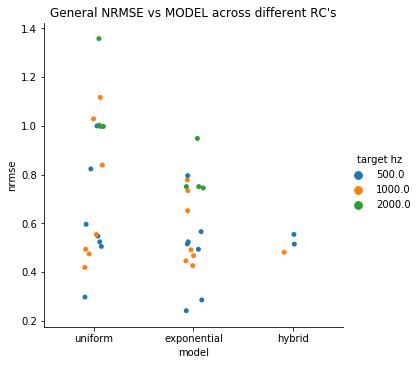

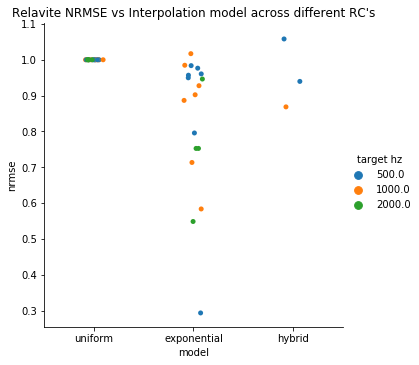

In [269]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

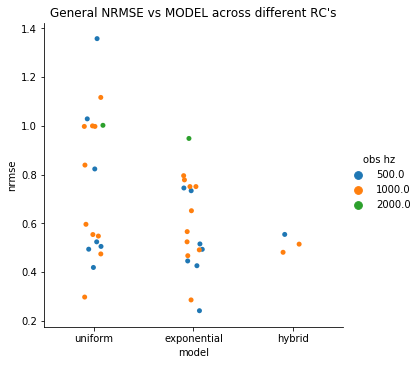

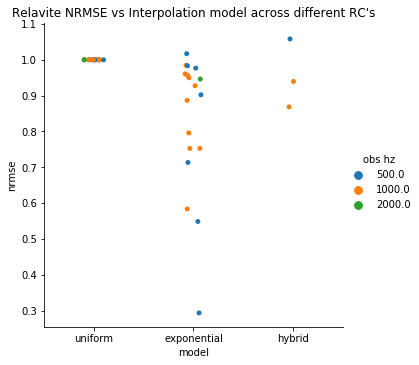

In [270]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

uniform


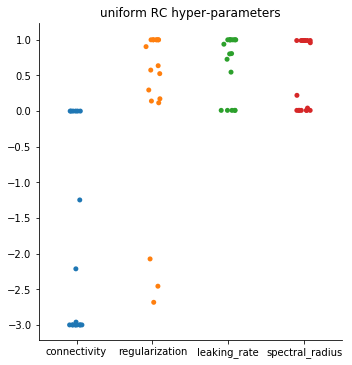

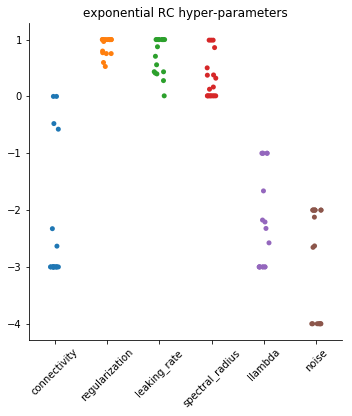

In [271]:
def hyper_parameter_plot(experiment_lst):
    """
    Let's visualize the hyper-parameter plots.
    """
    log_vars = ["noise", "connectivity", "regularization", "llambda"]
    
    for i, experiment in enumerate(experiment_lst):
        df_spec_unif = pd.DataFrame(experiment["best arguments"]["uniform"], index = [0])
        df_spec_exp  = pd.DataFrame(experiment["best arguments"]["exponential"], index = [0])
        if i == 0:
            df_unif = df_spec_unif
        else:
            df_unif = pd.concat([df_unif, df_spec_unif])
        if i == 0:
            df_exp = df_spec_exp
        else:
            df_exp = pd.concat([df_exp, df_spec_exp])
    print("uniform")
    unif_vars = ["connectivity", "regularization", "leaking_rate", "spectral_radius"]
    exp_vars  = ["llambda", "noise"]
    df_unif = df_unif[unif_vars]
    df_exp = df_exp[unif_vars + exp_vars]
    
    for i in list(df_unif.columns):
        if i in log_vars:
            df_unif[i] = np.log(df_unif[i])/np.log(10)
            
    for i in list(df_exp.columns):
        if i in log_vars:
            df_exp[i] = np.log(df_exp[i])/np.log(10)
    
    
    #display(df_unif)
    
    sns.catplot(data = df_unif)
    plt.title("uniform RC hyper-parameters")
    plt.show()
    
    
    sns.catplot(data = df_exp)
    plt.title("exponential RC hyper-parameters")
    plt.xticks(rotation=45)
    plt.show()

    #display(df_exp)
   
hyper_parameter_plot(experiment_lst)

# Old experiments

/Users/hayden/Desktop/experiment_results/2k/medium/
{'interpolation': 0.0395523911947735, 'uniform': 0.008455659375210041, 'exponential': 0.008443754314894253}


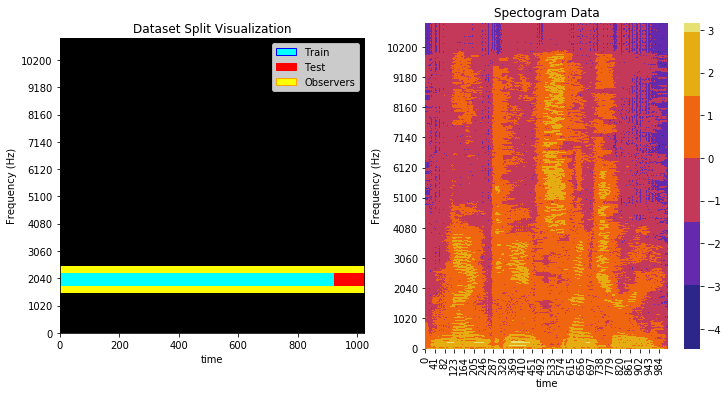

(103, 51)
(103, 52)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039552,0.008456,0.008444


unif improvement vs interpolation: nrmse -78.6%
exp improvement vs interpolation: nrmse -78.7%
exp rc improvement vs unif rc: nrmse -0.1%
/Users/hayden/Desktop/experiment_results/2k/medium/
{'interpolation': 0.03909516122428118, 'uniform': 0.013463952460055623, 'exponential': 0.009400709001748447}


<Figure size 640x480 with 0 Axes>

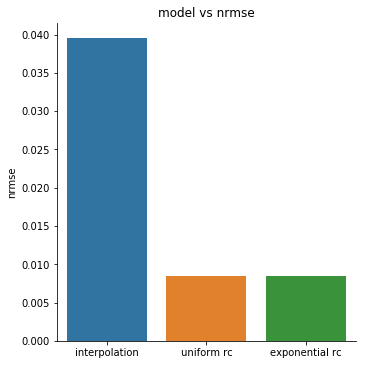

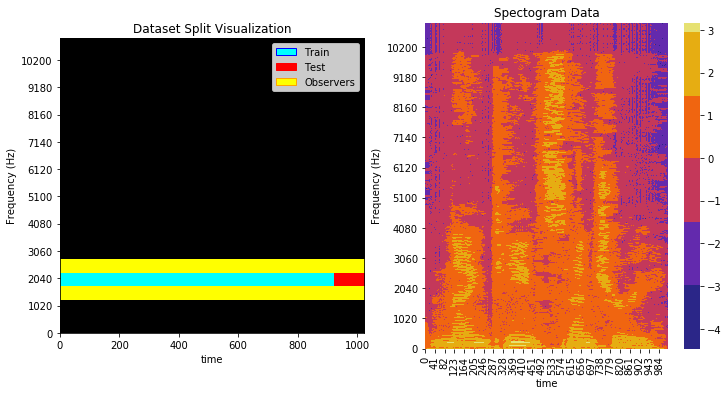

(103, 51)
(103, 102)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039095,0.013464,0.009401


unif improvement vs interpolation: nrmse -65.6%
exp improvement vs interpolation: nrmse -76.0%
exp rc improvement vs unif rc: nrmse -30.2%


NameError: name 'merge_unif_exp' is not defined

<Figure size 640x480 with 0 Axes>

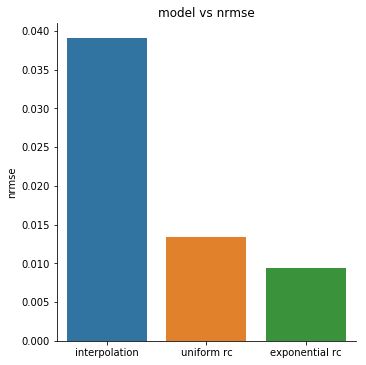

In [5]:
experiment_1 = topline("split_0.9/targetKhz:_0.5__obskHz:_0.5.txt", print_filestructure = False)
#hh = load_data()
#print(loadA.shape)
experiment_1_obj = get_experiment(experiment_1)


experiment_2 = topline("split_0.9/targetKhz:_0.5__obskHz:_1.0.txt") 
experiment_2_obj = get_experiment(experiment_2)

fp_exp1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/exp_targetKhz:_0.5__obskHz:_1.0.txt'
fp_unif1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/targetKhz:_0.5__obskHz:_1.0.txt'
experiment_3 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_3_obj = get_experiment(experiment_3)


#0.5split_0.5_0.5
fp_unif1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/unif_targetKhz:_0.5__obskHz:_0.5.txt'
fp_exp1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/targetKhz:_0.5__obskHz:_0.5.txt'
experiment_4 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_4_obj = get_experiment(experiment_4)

experiment_5 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

experiment_6 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_6_obj = get_experiment(experiment_6)

experiment_7 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_7_obj = get_experiment(experiment_7)

experiment_8 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_8_obj = get_experiment(experiment_8)

In [74]:
for i, experiment in enumerate(experiment_lst):
    #print(experiment['get_observer_inputs'].keys())
    split = experiment['get_observer_inputs']["split"]
    targ_hz = experiment['experiment_inputs']["target_hz"]
    targ_idx_LB, targ_idx_UB = experiment["resp_idx"][0], experiment["resp_idx"][-1]
    obs_hz = experiment['experiment_inputs']["obs_hz"]
    f = np.array(experiment_8_obj.f)
    obs_idx = experiment["obs_idx"] 

    obs_idx  = [int(j) for j in experiment["obs_idx"] ]
    obs_freq = [max(f) - f[j] for j in obs_idx]
    
    
    print("\nexperiment: " + str(i) + ", target hz: " + str(targ_hz) + ", obs hz: " + str(obs_hz) +
         ", split: " + str(split))

    
    print("target idx: [" + str(targ_idx_LB) + ", " + str(targ_idx_UB) + "]")
    print("target freq: [" + str(max(f) - f[targ_idx_LB]) + ", " + str(max(f) - f[targ_idx_UB]) + "]")
    print("obs idx: " + str(obs_idx))
    print("obs freq: " + str(obs_freq))
    print(experiment_8_obj.A.shape[0] - np.array(experiment["prediction"]["interpolation"]).shape[0])
    print(experiment_8_obj.A.shape[0])
    #print(experiment["resp_idx"])


experiment: 0, target hz: 1000.0, obs hz: 1000.0, split: 0.5
target idx: [853, 953]
target freq: [2490, 1490]
obs idx: [802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004]
obs freq: [3000, 2990, 2980, 2970, 2960, 2950, 2940, 2930, 2920, 2910, 2900, 2890, 2880, 2870, 2860, 2850, 2840, 2830, 2820, 2810, 2800, 2790, 2780, 2770, 2760, 2750, 2740, 2730, 2720, 2710, 2700, 2690, 2680, 2670, 2660, 2650, 2640, 2630, 2620, 2610, 2600, 2590, 2580, 2570, 2560, 2550, 2540, 2530, 2520, 2510, 2500, 1480, 1470, 1460, 1450, 1440, 1430, 1420, 1410,

In [ ]:
def show_exp_weights(json_obj, llambda = None):
    print(json_obj.keys())
    esn_ = EchoStateNetwork(**json_obj["best arguments"]["exponential"], plot = True)
    esn_.obs_idx  = json_obj["obs_idx"]
    esn_.resp_idx = json_obj["resp_idx"]
    if llambda != None:
        esn_.llambda = llambda
    esn_.get_exp_weights()


for i in experiment_lst:
    show_exp_weights(i)  
#show_exp_weights(experiment_2)  



In [ ]:
show_exp_weights(i, llambda = 10**-3) 

In [ ]:
10**-2 
np.log(10**-4)/np.log(10)


In [ ]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

#obs_hz_lst  *= 3
#targ_hz_lst *= 3

obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_0.5.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = load_data("experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")#topline("split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.5/targetKhz:_0.5__obskHz:_0.5.txt")  #GOOD!
#get_experiment(hi)
get_experiment(hi)

In [ ]:


def merge_unif_exp(fp_unif, fp_exp):
    exp_dat = load_data(fp_exp)
    unif_dat = load_data(fp_unif)
    assert exp_dat["prediction"]["interpolation"] == unif_dat["prediction"]["interpolation"], "something is wrong!"
    joint_dat = unif_dat.copy()
    for i in ["prediction", "nrmse", "best arguments"]:
        exp_dict = {"exponential" : exp_dat[i]["exponential"]}
        joint_dat[i] = Merge(joint_dat[i], exp_dict)
    print(joint_dat["best arguments"])
        
     
    return(joint_dat)
#0.5_1.0


In [ ]:
experiment_lst =[experiment_1, experiment_2, experiment_3, experiment_4,
                 experiment_5, experiment_6, experiment_7, experiment_8
                ]

NameError: name 'hyper_parameter_plot' is not defined

In [ ]:
hi = load_data('experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt')
get_experiment(hi) # broken

In [ ]:
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)